In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [84]:
# Trade data

stock_name = 'AAPL.O'
#NSQ_OneYear100closeA_Sept21.csv
df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
# Data Processing (10 minute intervals)
df_vol = pd.DataFrame(columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'log_returns'])
dates = apple['Date'].unique()
daily_volatility = []
daily_volatility_minus4pm = []
daily_return = []
avg_20day_volatility = []
stocks = []
dates_final = []
auction_log_returns = []
auction_log_returns_340350 = []
volumes = []
i = 1
for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min_volume = pd.DataFrame(apple_today['Volume'].resample("10T").sum())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    apple_today_10min = apple_today_10min.join(apple_today_10min_volume)
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    apple_today_10min['log_returns'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1) * np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
    volatility_today = apple_today_10min['log_returns'].values
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
    frames = [df_vol,apple_today_10min]
    df_vol = pd.concat(frames)



### Model 1A

Question 1A: How well does $\sigma_{t}^{2}$ forecast $\sigma_{t+1}^{2}$ ? Is it biased?

In [87]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
dates_final = []
stocks = []
daily_return = []
auction_log_returns = []
auction_log_returns_340350 = []
daily_volatility = []
daily_volatility_minus4pm = []
avg_20day_volatility = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    
    # Garman and Klass Volatility formula
    apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    
    volatility_today = apple_today_10min['Volatility'].values
    return_today = (apple_today_10min['Close']/apple_today_10min['Open']).values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Daily raw return
    daily_return.append(return_today)
        
    # Auction Volatility Information
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility.append(sum(volatility_today))
    daily_volatility_minus4pm.append(sum(volatility_today[:-1]))

daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model


In [88]:
df_mod1A = pd.DataFrame()
r1 = volatility_df['Date'].values
df_mod1A['Date'] = r1[20:]
df_mod1A['Actual Volatility'] = daily_volatility[20:]
df_mod1A['Predicted Volatility'] = avg_20day_volatility_raw[20:] # span=20 EWMA up to t-1

In [89]:
df_mod1A

,Date,Actual Volatility,Predicted Volatility
0,2020-09-30,0.104200,0.148068
1,2020-10-01,0.093920,0.143308
2,2020-10-02,0.132340,0.13802
3,2020-10-05,0.063825,0.137419
4,2020-10-06,0.130587,0.129712
...,...,...,...
226,2021-08-26,0.047295,0.055463
227,2021-08-27,0.045832,0.054685
228,2021-08-30,0.051515,0.053842
229,2021-08-31,0.057197,0.053621


In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(mean_absolute_error(df_mod1A['Actual Volatility'][1:], df_mod1A['Predicted Volatility'][1:]))
print(mean_squared_error(df_mod1A['Actual Volatility'][1:], df_mod1A['Predicted Volatility'][1:]))
print(r2_score(df_mod1A['Actual Volatility'][1:], df_mod1A['Predicted Volatility'][1:]))

0.018436630417850812
0.0006107220290630925
0.288246946027917


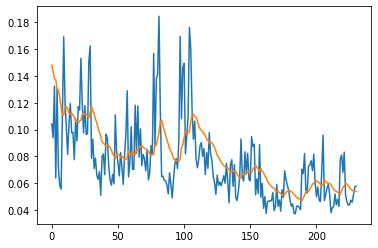

In [91]:
plt.plot(df_mod1A['Actual Volatility'])
plt.plot(df_mod1A['Predicted Volatility'])

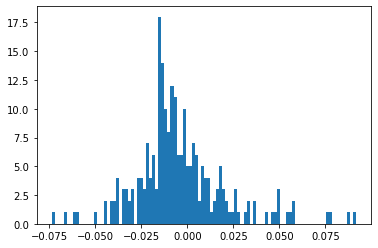

In [92]:
plt.hist(df_mod1A['Actual Volatility'] - df_mod1A['Predicted Volatility'], bins=100)
plt.show()

### Model 1B

Question 1B: How well does $\sigma_{t,B}^{2}$ forecast $\sigma_{t+1,B}^{2}$ ? Is it biased?

In [93]:
volatility_df['auction'] = volatility_df['daily_volatility'] - volatility_df['daily_volatility_minus4pm']
volatility_df['volatility_ewma20_auction'] = np.array([None] + [i for i in volatility_df['auction'].ewm(span=20).mean()][:-1])
volatility_df

,Date,daily_volatility,daily_volatility_minus4pm,volatility_ewma20,auction,volatility_ewma20_auction
0,2020-09-01,0.107893,0.103011,None,0.004882,None
1,2020-09-02,0.213729,0.210907,0.107893,0.002822,0.004882
2,2020-09-03,0.230712,0.224828,0.163457,0.005884,0.003801
3,2020-09-04,0.394455,0.386943,0.188153,0.007512,0.004566
4,2020-09-08,0.232716,0.228043,0.247709,0.004673,0.005416
...,...,...,...,...,...,...
246,2021-08-26,0.047295,0.045973,0.055463,0.001322,0.001479
247,2021-08-27,0.045832,0.044753,0.054685,0.001078,0.001464
248,2021-08-30,0.051515,0.050248,0.053842,0.001267,0.001427
249,2021-08-31,0.057197,0.053891,0.053621,0.003306,0.001412


In [94]:
df_mod1B = pd.DataFrame()
df_mod1B['Date'] = volatility_df['Date'][20:]
df_mod1B['Actual Volatility'] = volatility_df['auction'][20:]
df_mod1B['Predicted Volatility'] = volatility_df['volatility_ewma20_auction'][20:]

In [95]:
df_mod1B

,Date,Actual Volatility,Predicted Volatility
20,2020-09-30,0.003531,0.003963
21,2020-10-01,0.003203,0.003916
22,2020-10-02,0.002804,0.00384
23,2020-10-05,0.001843,0.00373
24,2020-10-06,0.003744,0.003532
...,...,...,...
246,2021-08-26,0.001322,0.001479
247,2021-08-27,0.001078,0.001464
248,2021-08-30,0.001267,0.001427
249,2021-08-31,0.003306,0.001412


In [96]:
print(mean_absolute_error(df_mod1B['Actual Volatility'][1:], df_mod1B['Predicted Volatility'][1:]))
print(mean_squared_error(df_mod1B['Actual Volatility'][1:], df_mod1B['Predicted Volatility'][1:]))
print(r2_score(df_mod1B['Actual Volatility'][1:], df_mod1B['Predicted Volatility'][1:]))

0.0009280381231897506
2.117114089756726e-06
0.11430866052145072


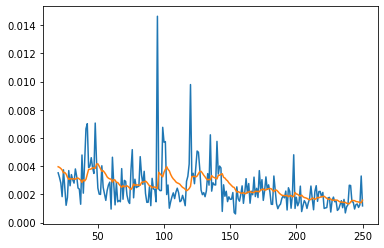

In [97]:
plt.plot(df_mod1B['Actual Volatility'])
plt.plot(df_mod1B['Predicted Volatility'])

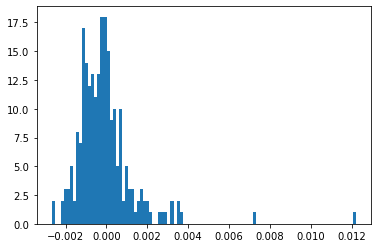

In [98]:
plt.hist(df_mod1B['Actual Volatility'] - df_mod1B['Predicted Volatility'], bins=100)
plt.show()

### Model 1C

Question 1C: How well does $\gamma\sigma_{t}^{2}$, where $\gamma = \dfrac{\sigma_{t+1,A}^{2}}{\sigma_{t,A}^{2}}$ forecast $\sigma_{t+1,B}^{2}$ ? Is it biased? \
(A corresponds to 9:30:00 to 15:49:59\
B corresponds to 15:50:00 to 16:00:00)

In [99]:
volatility_df['daily_volatility_minus4pm_yest'] = volatility_df['daily_volatility_minus4pm'].shift(1)
volatility_df['volatility_ewma20_auction_1c'] = volatility_df['daily_volatility_minus4pm']/volatility_df['daily_volatility_minus4pm_yest']*volatility_df['volatility_ewma20_auction']


In [100]:
df_mod1C = pd.DataFrame()
df_mod1C['Date'] = volatility_df['Date'][20:]
df_mod1C['Actual Volatility'] = volatility_df['auction'][20:]
df_mod1C['Predicted Volatility'] = volatility_df['volatility_ewma20_auction_1c'][20:]

In [101]:
print(mean_absolute_error(df_mod1C['Actual Volatility'][1:], df_mod1C['Predicted Volatility'][1:]))
print(mean_squared_error(df_mod1C['Actual Volatility'][1:], df_mod1C['Predicted Volatility'][1:]))
print(r2_score(df_mod1C['Actual Volatility'][1:], df_mod1C['Predicted Volatility'][1:]))

0.001019520872109536
2.3168734520181566e-06
0.03073964646088223


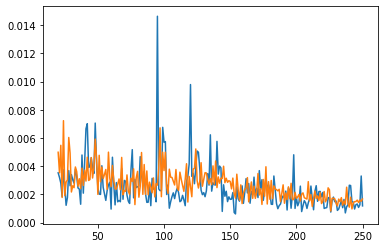

In [102]:
plt.plot(df_mod1C['Actual Volatility'])
plt.plot(df_mod1C['Predicted Volatility'])

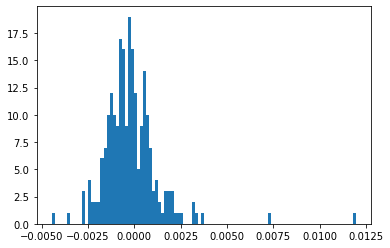

In [103]:
plt.hist(df_mod1C['Actual Volatility'] - df_mod1C['Predicted Volatility'], bins=100)
plt.show()